In [1]:
from keras import layers
from keras import models

from keras.datasets import mnist
from keras.utils import to_categorical
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

import os, shutil
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# to avoid a cuBLAS error, per https://stackoverflow.com/questions/43990046/tensorflow-blas-gemm-launch-failed
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# MNIST using a convolutional neural network

For comparison, a simple linear classifer (using only a few Dense layers, if I remember correctly) topped out at around 97% accuracy. Not bad, but the also simple convnet below gives us 99.3% accuracy. Both train in a similar and relatively short amount of time - the network below does five epochs of 60K inputs/digits in about 25s. 

In [3]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [4]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


In [5]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [6]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)               

In [7]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

train_images.shape, test_images.shape, train_labels.shape, test_labels.shape

((60000, 28, 28, 1), (10000, 28, 28, 1), (60000, 10), (10000, 10))

In [8]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5, batch_size=64, verbose=True)

Epoch 1/5
60000/60000 [==============================] - 6s 98us/step - loss: 0.1739 - accuracy: 0.9461
Epoch 2/5
60000/60000 [==============================] - 5s 81us/step - loss: 0.0470 - accuracy: 0.9854
Epoch 3/5
60000/60000 [==============================] - 5s 80us/step - loss: 0.0329 - accuracy: 0.9901
Epoch 4/5
60000/60000 [==============================] - 5s 80us/step - loss: 0.0255 - accuracy: 0.9924
Epoch 5/5
60000/60000 [==============================] - 5s 80us/step - loss: 0.0196 - accuracy: 0.9939


In [9]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
test_loss, test_accuracy

10000/10000 [==============================] - 1s 72us/step


(0.027074831167704268, 0.9912999868392944)

# More complicated (but not that complicated) images - starting with a simple model (no augmentation, etc.)

First, move the data - images - into separate directories for train, validation, and test.

In [3]:
os.getcwd()

'D:\\work\\github\\DeepLearningWithPython'

In [4]:
original_dataset_dir = 'dogsandcats_source'
base_dir = 'dogsandcats_small'
os.makedirs(base_dir, exist_ok=True)

# ugh, lots of duplication - i'm just using the code in the book, and I won't bother fixing it
train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)
validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(validation_dir, exist_ok=True)
test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

train_cats_dir = os.path.join(train_dir, 'cats')
os.makedirs(train_cats_dir, exist_ok=True)
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.makedirs(train_dogs_dir, exist_ok=True)
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.makedirs(validation_cats_dir, exist_ok=True)
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.makedirs(validation_dogs_dir, exist_ok=True)

test_cats_dir = os.path.join(test_dir, 'cats')
os.makedirs(test_cats_dir, exist_ok=True)
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.makedirs(test_dogs_dir, exist_ok=True)

In [5]:
need_to_copy_files = False

train_size = 1000
validation_size = 500
test_size = 500

if need_to_copy_files:
    # ugh, even more duplication
    fnames = ['cat.{}.jpg'.format(i) for i in range(train_size)]
    for fname in fnames:
        src = os.path.join(original_dataset_dir, fname)
        dst = os.path.join(train_cats_dir, fname)
        shutil.copyfile(src, dst)

    fnames = ['cat.{}.jpg'.format(i) for i in range(train_size, train_size + validation_size)]
    for fname in fnames:
        src = os.path.join(original_dataset_dir, fname)
        dst = os.path.join(validation_cats_dir, fname)
        shutil.copyfile(src, dst)

    fnames = ['cat.{}.jpg'.format(i) for i in range(train_size + validation_size, train_size + validation_size + test_size)]
    for fname in fnames:
        src = os.path.join(original_dataset_dir, fname)
        dst = os.path.join(test_cats_dir, fname)
        shutil.copyfile(src, dst)

    fnames = ['dog.{}.jpg'.format(i) for i in range(train_size)]
    for fname in fnames:
        src = os.path.join(original_dataset_dir, fname)
        dst = os.path.join(train_dogs_dir, fname)
        shutil.copyfile(src, dst)

    fnames = ['dog.{}.jpg'.format(i) for i in range(train_size, train_size + validation_size)]
    for fname in fnames:
        src = os.path.join(original_dataset_dir, fname)
        dst = os.path.join(validation_dogs_dir, fname)
        shutil.copyfile(src, dst)

    fnames = ['dog.{}.jpg'.format(i) for i in range(train_size + validation_size, train_size + validation_size + test_size)]
    for fname in fnames:
        src = os.path.join(original_dataset_dir, fname)
        dst = os.path.join(test_dogs_dir, fname)
        shutil.copyfile(src, dst)

## Build the model - don't need to run this if you're just setting up things above for use below

And build the model.

In [19]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)      

In [21]:
model.compile(loss='binary_crossentropy',
optimizer=optimizers.RMSprop(lr=1e-4),
metrics=['acc'])

And pre-process the data - decode jpeg to RGB, convert to floating point tensors, rescale 0-255 to 0-1. 

In [22]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(150, 150), 
                                                    batch_size=20, 
                                                    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(150, 150),
                                                        batch_size=20,
                                                        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


And then run and save the model.

Interesting to me that the first time I ran this, the first epoch took 20s and each subsequent epoch took ~5s (except for the last two epochs, which took 15s and 10s, for some reason - in later runs I also got every once in a while a long-running epoch, at different points - not sure why) - perhaps caching, somewhere or in multiple places? When I ran it a second time, the first epoch took the same 5s, so it's likely using whatever cache was set up before. It's also the case that the cache appears to be below the process level, at least - if I restarted Jupyter, the first run was still fast. But restarting the machine made it 20+s again. I watched Task Manager while it was happening and as expected the disk and GPU copy operations were in use. Running it again, hot, and the initial time where the GPU does some data/copy stuff appears to not be there. I could also see the 'dedicated GPU memory usage' graph down below go from about 2GB to 3.5GB (on my old 970 with, it appears, 4GB of RAM).

Also interesting is that if you just re-run the line below - just the fit_generator call - then it appears to pick up (perhaps?) where it left off? At least there's no initial few epochs w/ a lot of learning like normal. Instead, it starts off as good as it was at the end before and finishes off just where it started. If I recreate the model object by running the code above again, then it starts off bad and improves, as I see the first time, and as expected.

In [23]:
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=30, 
                              validation_data=validation_generator, validation_steps=50)

model.save('dogsandcats_small_1.h5')

Epoch 1/30
100/100 [==============================] - 5s 55ms/step - loss: 0.6870 - acc: 0.5360 - val_loss: 0.8047 - val_acc: 0.5000
Epoch 2/30
100/100 [==============================] - 6s 58ms/step - loss: 0.6557 - acc: 0.6130 - val_loss: 0.4993 - val_acc: 0.6340
Epoch 3/30
100/100 [==============================] - 5s 50ms/step - loss: 0.6150 - acc: 0.6555 - val_loss: 0.6154 - val_acc: 0.6360
Epoch 4/30
100/100 [==============================] - 5s 48ms/step - loss: 0.5758 - acc: 0.6910 - val_loss: 0.5803 - val_acc: 0.6540
Epoch 5/30
100/100 [==============================] - 5s 48ms/step - loss: 0.5407 - acc: 0.7230 - val_loss: 0.4954 - val_acc: 0.6910
Epoch 6/30
100/100 [==============================] - 5s 48ms/step - loss: 0.5143 - acc: 0.7465 - val_loss: 0.6705 - val_acc: 0.6830
Epoch 7/30
100/100 [==============================] - 5s 48ms/step - loss: 0.4860 - acc: 0.7615 - val_loss: 0.5124 - val_acc: 0.7110
Epoch 8/30
100/100 [==============================] - 5s 48ms/step - 

In [24]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

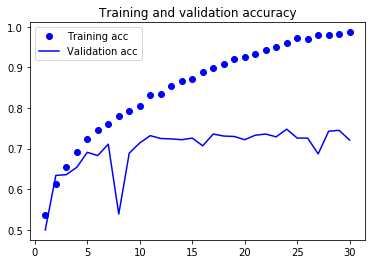

In [25]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

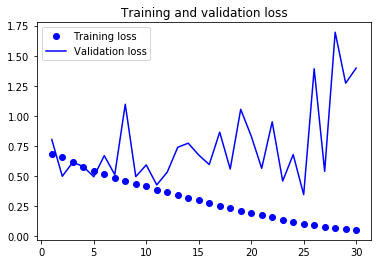

In [26]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

# Adding data augmentation

In [27]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

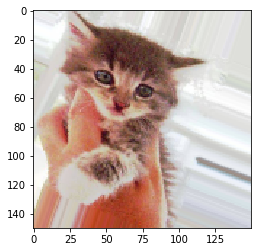

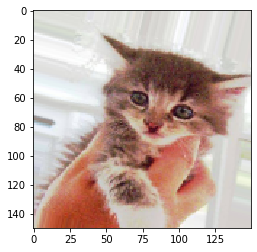

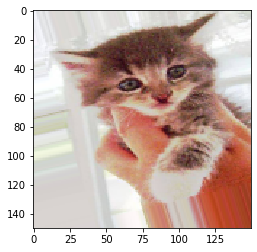

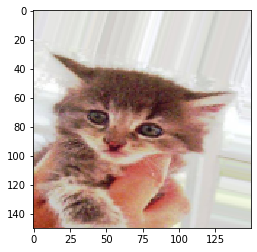

In [30]:
fnames = [os.path.join(train_cats_dir, fname) for
    fname in os.listdir(train_cats_dir)]

img_path = fnames[3]
img = image.load_img(img_path, target_size=(150, 150))

x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0

for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

Try a new model, with dropout regularization (and we'll also use the augmented images from the data generator). 

In [31]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

In [32]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 15, 15, 128)      

In [33]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Judging from the training time, which is 20s for the first epoch and then stays at about 20s throughout, the image augmentation is at a minimum keeping the GPU from using the same images over and over... I take this to mean that there's either processing and so each epoch sees new (augmented) images (more likely, and I could look it up to confirm), or I suppose that the images generated are re-used but that something in the pipeline prevents caching from happening. However, if - as I think the graphs below will show - the train and validation loss and accuracy metrics stay pretty much in sync (instead of diverging) and keep increasing, that's also evidence that we're getting new data each time. Also, the flattening of the curves I think tells me that the new data becomes successively less useful, which makes sense at least because it's not really _new_ - it's just transformed using a set of rules. (I think I may have enough source data that I could try giving it completely new images each time and see how the graphs compared, if I wanted to.) 

Another interesting thing, at least at a glance, is that the GPU operations - judging from the graphs in Task Manager - aren't as extensive (the graphs don't go as high) as with the model above. Perhaps this is because there's a good amount of augmentation happening that doesn't work on the GPU? And so the relative amount of GPU-taxing is lower here? 

Finally, running the below does take a while - 100 epochs at 20s an epoch is ~33m. This is on a GTX 970.

In [34]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 20s 199ms/step - loss: 0.6914 - acc: 0.5323 - val_loss: 0.6752 - val_acc: 0.5438
Epoch 2/100
100/100 [==============================] - 18s 183ms/step - loss: 0.6801 - acc: 0.5653 - val_loss: 0.5800 - val_acc: 0.5992
Epoch 3/100
100/100 [==============================] - 18s 185ms/step - loss: 0.6661 - acc: 0.5798 - val_loss: 0.6940 - val_acc: 0.6244
Epoch 4/100
100/100 [==============================] - 19s 187ms/step - loss: 0.6497 - acc: 0.6177 - val_loss: 0.5803 - val_acc: 0.6572
Epoch 5/100
100/100 [==============================] - 18s 183ms/step - loss: 0.6243 - acc: 0.6499 - val_loss: 0.6208 - val_acc: 0.5882
Epoch 6/100
100/100 [==============================] - 20s 199ms/step - loss: 0.6029 - acc: 0.6730 - val_loss: 0.4825 - val_acc: 0.6843
Epoch 7/100
100/100 [==============================] - 18s 183ms/step - loss: 0.6009 - acc: 0.6737 - val_loss: 0.5449 - val_acc: 0.7075
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 18s 185ms/step - loss: 0.4056 - acc: 0.8100 - val_loss: 0.4347 - val_acc: 0.7983
Epoch 62/100
100/100 [==============================] - 19s 186ms/step - loss: 0.4233 - acc: 0.8024 - val_loss: 0.2331 - val_acc: 0.7906
Epoch 63/100
100/100 [==============================] - 19s 187ms/step - loss: 0.3918 - acc: 0.8285 - val_loss: 0.4696 - val_acc: 0.8099
Epoch 64/100
100/100 [==============================] - 18s 181ms/step - loss: 0.3991 - acc: 0.8144 - val_loss: 0.5179 - val_acc: 0.7919
Epoch 65/100
100/100 [==============================] - 18s 182ms/step - loss: 0.4048 - acc: 0.8134 - val_loss: 0.5947 - val_acc: 0.8217
Epoch 66/100
100/100 [==============================] - 18s 182ms/step - loss: 0.3958 - acc: 0.8213 - val_loss: 0.7253 - val_acc: 0.8041
Epoch 67/100
100/100 [==============================] - 18s 183ms/step - loss: 0.4029 - acc: 0.8169 - val_loss: 0.5411 - val_acc: 0.8096
Epoch 68/100
100/100 [===================

In [36]:
# should have been at the end of the prev cell, but I don't want to re-run it now to make it happen that way
model.save('dogsandcats_small_2.h5')

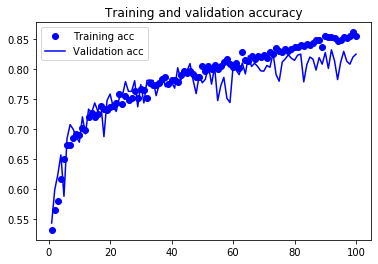

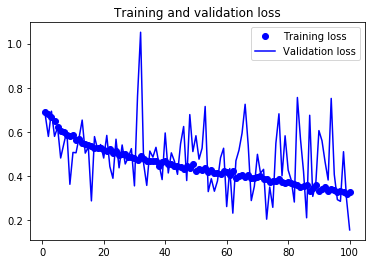

In [37]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

# Use a pre-trained convnet

This is what the book calls 'feature extraction' - it's what we did in class: you use a pre-trained model to get features and then build a last layer on top to do your final classification, or use.

In [6]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [7]:
type(conv_base)

keras.engine.training.Model

In [8]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## Fast feature extraction w/o augmentation

One approach is to run the pre-trained model over the dataset once, recording the output separately. Then build a separate model to actual do the classification, where the separate model takes in the output of the first step instead of the actual images. This is fast because you only need to do the expensive convolutional part once. However, it means you can't use augmentation because you're fixing/choosing the data up-front (although I suppose you could do augmentation before you do the first step - this would be somewhere between not doing it at all and doing it uniquely for each iteration/epoch as above - you'd just get a much larger dataset that you'd fix/make static). 

In [12]:
base_dir, train_dir, validation_dir, test_dir

('dogsandcats_small',
 'dogsandcats_small\\train',
 'dogsandcats_small\\validation',
 'dogsandcats_small\\test')

In [13]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512)) # 4,4,12 is the size of the last layer in the pre-trained model
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory,
                                            target_size=(150, 150),
                                            batch_size=batch_size,
                                            class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break # generators go for ever, so we stop manually
    return features, labels

In [14]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [15]:
train_features.shape, train_labels.shape, validation_features.shape, validation_labels.shape, test_features.shape, test_labels.shape

((2000, 4, 4, 512),
 (2000,),
 (1000, 4, 4, 512),
 (1000,),
 (1000, 4, 4, 512),
 (1000,))

In [16]:
reshaped_size = 4 * 4 * 512
train_features = np.reshape(train_features, (len(train_features), reshaped_size))
validation_features = np.reshape(validation_features, (len(validation_features), reshaped_size))
test_features = np.reshape(test_features, (len(test_features), reshaped_size))
train_features.shape, validation_features.shape, test_features.shape

((2000, 8192), (1000, 8192), (1000, 8192))

In [50]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=reshaped_size))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 453us/step - loss: 0.5968 - acc: 0.6680 - val_loss: 0.4500 - val_acc: 0.8290
Epoch 2/30
2000/2000 [==============================] - 1s 390us/step - loss: 0.4363 - acc: 0.8025 - val_loss: 0.3672 - val_acc: 0.8580
Epoch 3/30
2000/2000 [==============================] - 1s 392us/step - loss: 0.3718 - acc: 0.8445 - val_loss: 0.3246 - val_acc: 0.8820
Epoch 4/30
2000/2000 [==============================] - 1s 389us/step - loss: 0.3213 - acc: 0.8705 - val_loss: 0.3015 - val_acc: 0.8860
Epoch 5/30
2000/2000 [==============================] - 1s 388us/step - loss: 0.2923 - acc: 0.8840 - val_loss: 0.2828 - val_acc: 0.8960
Epoch 6/30
2000/2000 [==============================] - 1s 390us/step - loss: 0.2698 - acc: 0.8905 - val_loss: 0.2718 - val_acc: 0.8940
Epoch 7/30
2000/2000 [==============================] - 1s 400us/step - loss: 0.2533 - acc: 0.8965 - val_loss: 0.2617 - val_acc: 0.8940


In [9]:
def output_plots(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [ ]:
output_plots(history)

So that's 90% validation accuracy, which is a good step up from the ~72% I got from the trained-from-scratch model above. 

## Feature extraction with data augmentation

The above plots show we start overfitting right away - the training accuracy passes the plateaued validation accuracy after only five or so epochs. Per the book, this is what happens when we have only a small amount of data. For images, we can help with augmentation... but it's expensive.

In [10]:
model = models.Sequential()
model.add(conv_base) # A model is just like a layer in Keras, so we can add the pre-trained model and just go from there.
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


We want to keep the weights in the pre-trained model, by 'freezing' them.

In [11]:
len(model.trainable_weights)

30

In [12]:
conv_base.trainable = False

# the two dense layers each have two weights - one for the weight matrix and one for the bias vector
len(model.trainable_weights)

4

In [13]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255) # we don't augment the validation data

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [14]:
model.compile(loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=2e-5),
    metrics=['acc'])

In [15]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    #epochs=30, # save a little time since at least for me I don't see a ton of diff after 15 (some but not a lot)
    epochs=15,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/15
100/100 [==============================] - 19s 192ms/step - loss: 0.6143 - acc: 0.6555 - val_loss: 0.5785 - val_acc: 0.8080
Epoch 2/15
100/100 [==============================] - 15s 152ms/step - loss: 0.4948 - acc: 0.7810 - val_loss: 0.5261 - val_acc: 0.8270
Epoch 3/15
100/100 [==============================] - 15s 151ms/step - loss: 0.4399 - acc: 0.8035 - val_loss: 0.3303 - val_acc: 0.8630
Epoch 4/15
100/100 [==============================] - 15s 152ms/step - loss: 0.4120 - acc: 0.8190 - val_loss: 0.2352 - val_acc: 0.8700
Epoch 5/15
100/100 [==============================] - 15s 153ms/step - loss: 0.3936 - acc: 0.8230 - val_loss: 0.4759 - val_acc: 0.8770
Epoch 6/15
100/100 [==============================] - 15s 152ms/step - loss: 0.3743 - acc: 0.8385 - val_loss: 0.4414 - val_acc: 0.8890
Epoch 7/15
100/100 [==============================] - 15s 152ms/step - loss: 0.3653 - acc: 0.8375 - val_loss: 0.2790 - val_acc: 0.8940
Epoch 8/15
100/100 [==============================] - 1

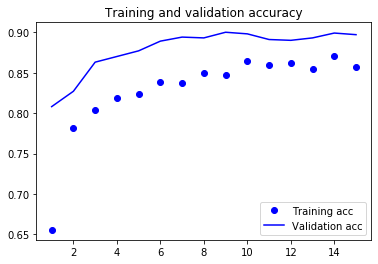

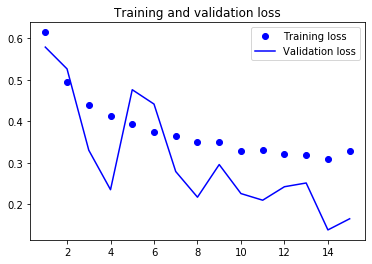

In [16]:
output_plots(history)

Hmmm - the book shows the training accuracy getting up a bit above the validation accuracy - they do stay together though, I think for the same reason written about above where we did augmentation w/ the from-scratch model (they're both seeing new data?). The book also shows a validation accuracy of around 95%, not the 90% I get here (which is the same as the 90% for the non-augmented model above). Hmm.

# Fine-tuning, another method, complementary to feature extraction

Unfreeze a few of the top layers of the previously-trained model, and then fine-tune them using the data we care about. Okey doke.

The first parts of this are to add the custom Dense/final ouput layer(s), freeze the entire base network, and train the part I added. This is exactly what I've already done above in the feature extraction work. If I'm running the notebook to do this section, I need to run the parts above before going on to the fine tuning.

Then, I unfreeze a few of the top layers in the base network, and then jointly train these layers and the ones I added on top of them. I'll do that here.

In [17]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [18]:
conv_base.layers[18].name.startswith('block5_conv')

False

In [19]:
# don't want to train the whole thing on the small amount of data I have because its 15M params will likely lead 
# to overfitting w/o a lot more data. 

# so, we'll just unfreeze and train the three 'block5' layers
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name.startswith('block5_conv'):
        layer.trainable = True
    else:
        layer.trainable = False

In [20]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [21]:
for layer in conv_base.layers:
    print(f'{layer.name} - {layer.trainable}')

input_1 - False
block1_conv1 - False
block1_conv2 - False
block1_pool - False
block2_conv1 - False
block2_conv2 - False
block2_pool - False
block3_conv1 - False
block3_conv2 - False
block3_conv3 - False
block3_pool - False
block4_conv1 - False
block4_conv2 - False
block4_conv3 - False
block4_pool - False
block5_conv1 - True
block5_conv2 - True
block5_conv3 - True
block5_pool - False


In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 9,732,929
Trainable params: 2,097,665
Non-trainable params: 7,635,264
_________________________________________________________________


C:\Users\andrewe\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [23]:
model.compile(loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=1e-5),
    metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    #epochs=30,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 17s 167ms/step - loss: 0.3072 - acc: 0.8565 - val_loss: 0.1661 - val_acc: 0.9100
Epoch 2/100
100/100 [==============================] - 16s 156ms/step - loss: 0.2738 - acc: 0.8795 - val_loss: 0.2275 - val_acc: 0.9060
Epoch 3/100
100/100 [==============================] - 17s 165ms/step - loss: 0.2554 - acc: 0.8930 - val_loss: 0.0410 - val_acc: 0.9140
Epoch 4/100
100/100 [==============================] - 31s 310ms/step - loss: 0.2336 - acc: 0.9070 - val_loss: 0.2426 - val_acc: 0.9230
Epoch 5/100
100/100 [==============================] - 22s 215ms/step - loss: 0.2169 - acc: 0.9040 - val_loss: 0.1179 - val_acc: 0.9220
Epoch 6/100
100/100 [==============================] - 15s 154ms/step - loss: 0.2067 - acc: 0.9085 - val_loss: 0.2387 - val_acc: 0.9110
Epoch 7/100
100/100 [==============================] - 15s 154ms/step - loss: 0.1980 - acc: 0.9195 - val_loss: 0.7081 - val_acc: 0.9100
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 21s 212ms/step - loss: 0.0363 - acc: 0.9900 - val_loss: 0.0332 - val_acc: 0.9420
Epoch 62/100
100/100 [==============================] - 30s 298ms/step - loss: 0.0257 - acc: 0.9890 - val_loss: 0.1724 - val_acc: 0.9450
Epoch 63/100
100/100 [==============================] - 16s 156ms/step - loss: 0.0350 - acc: 0.9875 - val_loss: 0.0403 - val_acc: 0.9440
Epoch 64/100
100/100 [==============================] - 15s 153ms/step - loss: 0.0230 - acc: 0.9920 - val_loss: 0.5708 - val_acc: 0.9480
Epoch 65/100
100/100 [==============================] - 15s 153ms/step - loss: 0.0358 - acc: 0.9870 - val_loss: 0.6624 - val_acc: 0.9160
Epoch 66/100
100/100 [==============================] - 15s 153ms/step - loss: 0.0256 - acc: 0.9885 - val_loss: 0.1852 - val_acc: 0.9310
Epoch 67/100
100/100 [==============================] - 15s 153ms/step - loss: 0.0314 - acc: 0.9880 - val_loss: 0.0538 - val_acc: 0.9340
Epoch 68/100
100/100 [===================

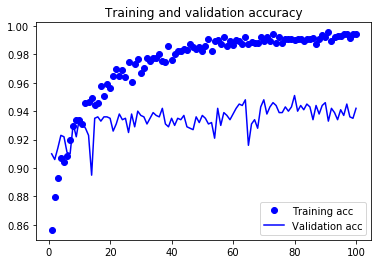

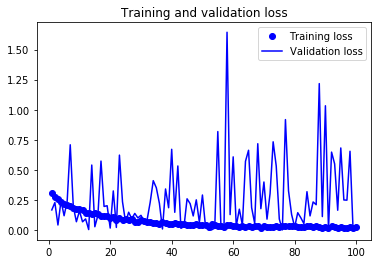

In [24]:
output_plots(history)

In [25]:
def smooth_curve(points, factor=0.8):
    """Per the book, this is an 'exponential moving average'."""
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

def output_plots(history, smoothed=False):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    if smoothed:
        plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
        plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
    else:
        plt.plot(epochs, acc, 'bo', label='Training acc')
        plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    
    plt.figure()
    if smoothed:
        plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
        plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
    else:
        plt.plot(epochs, loss, 'bo', label='Training loss')
        plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

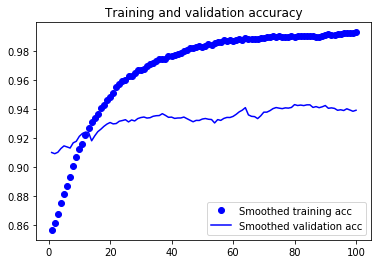

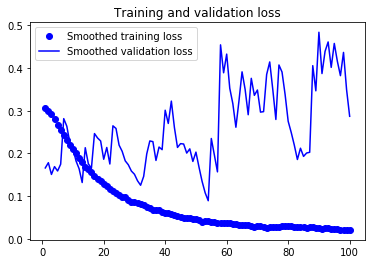

In [26]:
output_plots(history, smoothed=True)

## And predict the test set, finally

According to the book, an accuracy of ~97% would have been one of the top results in the original Kaggle competition (which was from a while back) AND with only using 2000 samples compared to the competition's 20,000 - and that the book says there's a 'huge difference' between 20K and 2K. We got this accuracy using 'only modern deep learning techniques', with 1/10 of the data.

Well, I'll see what I get w/ the last model from above. Hmm... I get 94% - good, but not the 97% the book shows. Hmm. Still, pretty cool that I can build it.

In [29]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

test_loss, test_acc = model.evaluate(test_generator, steps=50)

test_acc

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 11s 223ms/step


0.9409999847412109

In [30]:
model.save('dogsandcats_small_vgg16withfinetuningandaug.h5')

# Visualizing what a convnet learns

## Visualizing intermediate convnet outputs/activations

Here we take a particular input - image - and then visualize the feature maps that are output by various layers - the output of a layer is sometimes called an 'activation', because it's the output of an activation function. This provides a few into how the input is decomposed into different filters learned by the network. We visualize in 3D: width, height, depth/channels. Each channel encodes relatively independent features, so we'll visualize as independent plots of every channel as a 2D image.

In [32]:
from keras.models import load_model
model = load_model('dogsandcats_small_2.h5')

In [33]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 15, 15, 128)      

In [34]:
test_dir

'dogsandcats_small\\test'

In [46]:
img_path = 'dogsandcats_small/test/cats/cat.1700.jpg'

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

img_tensor.shape, img_tensor[0].shape, len(img_tensor)

((1, 150, 150, 3), (150, 150, 3), 1)

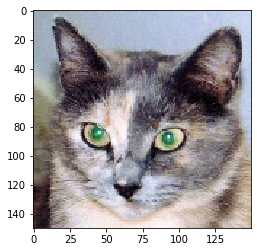

In [42]:
plt. (img_tensor[0])

In [47]:
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [48]:
activations = activation_model.predict(img_tensor)

In [49]:
first_layer_activation = activations[0]
first_layer_activation.shape

(1, 148, 148, 32)

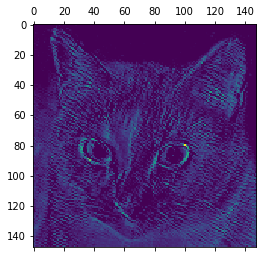

In [54]:
plt.matshow(first_layer_activation[0, :, :, 31], cmap='viridis')

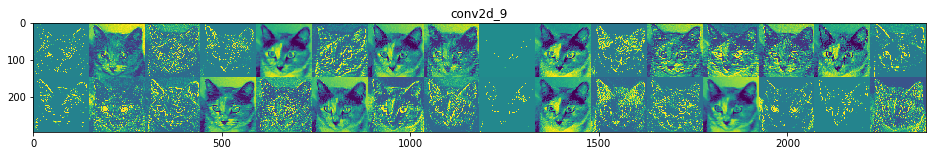

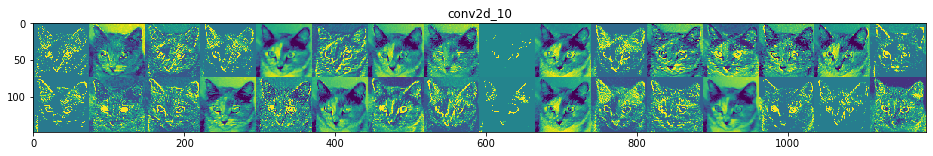

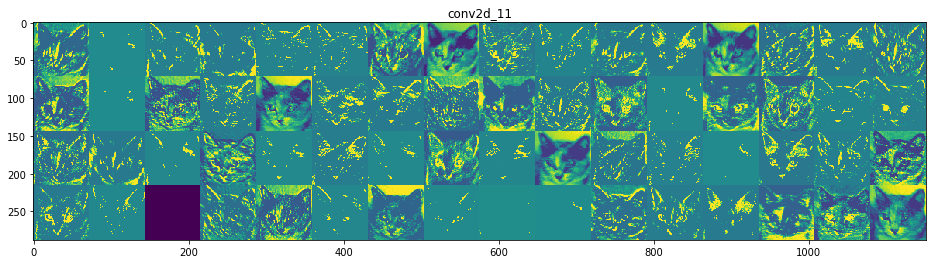

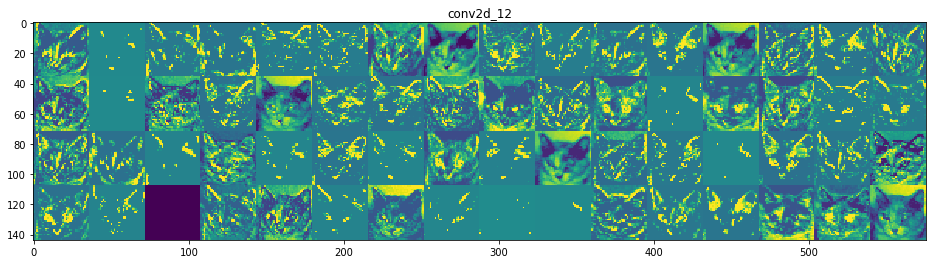

In [58]:
layer_names = []
for layer in model.layers[:8]:
    if layer.name.startswith('conv'): # skip max pooling layers
        layer_names.append(layer.name)
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1] # number of features in the feature map
    
    size = layer_activation.shape[1] # feature map has shape (1, size, size, n_features)
    
    n_cols = n_features // images_per_row # tile the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            
            # post-process the image to make it 'visually palatable'
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image
            
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [59]:
model.predict(img_tensor)

array([[0.01678919]], dtype=float32)

In [60]:
img_path = 'rhyme.png'

img_rhyme = image.load_img(img_path, target_size=(150, 150))
img_tensor_rhyme = image.img_to_array(img_rhyme)
img_tensor_rhyme = np.expand_dims(img_tensor_rhyme, axis=0)
img_tensor_rhyme /= 255.

img_tensor_rhyme.shape, img_tensor_rhyme[0].shape, len(img_tensor_rhyme)

((1, 150, 150, 3), (150, 150, 3), 1)

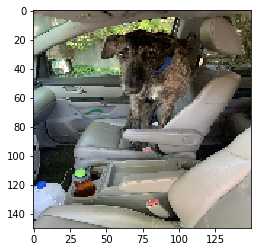

In [61]:
plt.imshow(img_rhyme)

In [62]:
model.predict(img_tensor_rhyme)

array([[0.04676881]], dtype=float32)

In [63]:
model = load_model('dogsandcats_small_vgg16withfinetuningandaug.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


In [64]:
model.predict(img_tensor_rhyme)

array([[0.9996865]], dtype=float32)

In [65]:
model.predict(img_tensor)

array([[5.55061e-25]], dtype=float32)